In [28]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from math import floor

In [2]:
tug = pd.read_csv('takehome_user_engagement.csv')

In [3]:
tu = pd.read_csv('takehome_users.csv', encoding='latin1')

In [4]:
tug.time_stamp = pd.to_datetime(tug.time_stamp)

In [5]:
tug = tug.set_index('time_stamp')

In [6]:
visits_by_user = tug.pivot_table('visited','user_id',aggfunc='sum').reset_index()

In [7]:
candidates = visits_by_user.loc[visits_by_user.visited > 2].user_id
canlist = candidates.tolist()

In [8]:
tug_can = tug.loc[tug.user_id.apply(lambda x: x in canlist)]

In [9]:
len(tug.user_id.unique())

8823

In [10]:
max(tug.index) - min(tug.index)

Timedelta('736 days 06:38:44')

In [11]:
tug[tug.user_id == 2].resample('7D').visited.sum()

time_stamp
2013-11-15 03:45:04    1.0
2013-11-22 03:45:04    NaN
2013-11-29 03:45:04    1.0
2013-12-06 03:45:04    1.0
2013-12-13 03:45:04    NaN
2013-12-20 03:45:04    1.0
2013-12-27 03:45:04    1.0
2014-01-03 03:45:04    1.0
2014-01-10 03:45:04    NaN
2014-01-17 03:45:04    NaN
2014-01-24 03:45:04    NaN
2014-01-31 03:45:04    1.0
2014-02-07 03:45:04    3.0
2014-02-14 03:45:04    1.0
2014-02-21 03:45:04    NaN
2014-02-28 03:45:04    NaN
2014-03-07 03:45:04    2.0
2014-03-14 03:45:04    NaN
2014-03-21 03:45:04    NaN
2014-03-28 03:45:04    1.0
Freq: 7D, Name: visited, dtype: float64

# Determine Adopted Users

In [12]:
def rolling_window_logins_check(logins_per_day, n_logins=3, window=7, min_periods=6):
    logins = (logins_per_day.rolling(window=window, min_periods=min_periods).sum().dropna() >= n_logins).sum()
    return logins >= n_logins

In [13]:
def make_logon_per_day_series(user_id):
    term = tug[tug.user_id==user_id].resample("1d").sum().fillna(0)['visited']
    if len(term) > 0:
        return term.apply(lambda x: x>0).astype(int)
    else:
        return term

In [14]:
rolling_window_logins_check(make_logon_per_day_series(user_id = 10))

True

In [15]:
active_user = []
for user_id  in tug.user_id.unique().tolist():
    active_user.append({'user_id':user_id,'active':rolling_window_logins_check(make_logon_per_day_series(user_id))})

In [16]:
actives_df = pd.DataFrame.from_records(active_user).set_index('user_id')

In [17]:
def get_user_active_flag(user_id):
    try:
        return actives_df.active[user_id]
    except:
        return False

In [18]:
actives_df.head()

,active
user_id,
1,False
2,True
3,False
4,False
5,False


In [19]:
tu['active'] = tu.object_id.apply(get_user_active_flag)

# Creating our Model's Dataset

We don't need the user_id or their name

In [20]:
model_tu = tu.copy()
model_tu = model_tu.drop(['object_id', 'name'], axis=1)

Convert the datetime strings into datetime objects

In [21]:
model_tu.last_session_creation_time = pd.to_datetime(model_tu.last_session_creation_time,unit='s')
model_tu.creation_time = pd.to_datetime(model_tu.creation_time)

User's age indicates the length of time between their first session (if any) and their last session

In [22]:
model_tu['age'] = model_tu.last_session_creation_time-model_tu.creation_time

In [23]:
model_tu.age.fillna(0).head()

0     0 days
1   136 days
2     0 days
3     1 days
4     5 days
Name: age, dtype: timedelta64[ns]

In [24]:
model_tu.age = model_tu.age.dt.days.fillna(0).astype(int)

The 'org_id' indicates what organization the user is apart of. Most organizations contain fewer than 50 users.

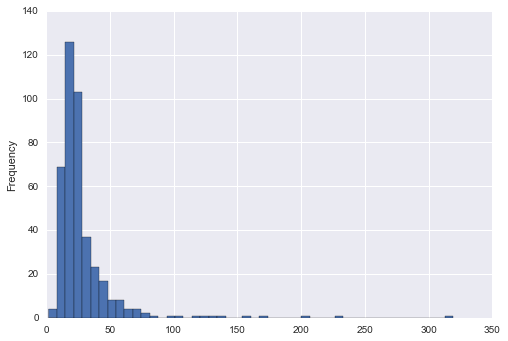

In [25]:
model_tu.org_id.value_counts().plot(kind='hist', bins=48)

In [26]:
def group_by_x(value, x):
    return floor(value / x) * x

In [29]:
org_counts = model_tu.org_id.value_counts()
org_counts = org_counts.apply(lambda x: group_by_x(x, 1))
model_tu['org_size'] = model_tu.org_id.apply(lambda x: org_counts.loc[x])

In [30]:
model_tu

,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,age,org_size
0,2014-04-22 03:53:30,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False,0,75
1,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,True,136,233
2,2013-03-19 23:14:52,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False,0,32
3,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False,1,233
4,2013-01-17 10:14:20,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False,5,16
5,2013-12-17 03:37:06,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,11241.0,False,2,14
6,2012-12-16 13:24:32,TylerSewell@jourrapide.com,SIGNUP,2012-12-20 13:24:32,0,1,37,NaN,False,4,44
7,2013-07-31 05:34:02,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,False,0,38
8,2013-11-05 04:04:24,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,False,0,19
9,2013-01-16 22:08:03,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03,1,1,318,4143.0,True,503,17


In [31]:
model_tu['invited_by_active'] = model_tu.invited_by_user_id.apply(get_user_active_flag)
model_tu['invited_by_inactive'] = model_tu.invited_by_user_id.apply(lambda x:~get_user_active_flag(x) if x is not np.nan else False)
model_tu.invited_by_inactive = model_tu.invited_by_inactive.replace(-1,False)

In [32]:
model_tu = model_tu.drop(['age','creation_time', 'email', 'last_session_creation_time', 'org_id',  'invited_by_user_id'], axis=1)
#model_tu = model_tu.drop(['age', 'creation_time', 'email', 'last_session_creation_time', 'invited_by_user_id'], axis=1)

# Model

In [33]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [34]:
forest = ExtraTreesClassifier(random_state=42)

In [35]:
rf_model_tu = pd.get_dummies(model_tu)

In [36]:
X = rf_model_tu.drop('active', axis=1)
y = rf_model_tu.active.values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.86888888888888893

In [39]:
def plot_rf_importances(forest):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    names = X_train.columns.tolist()
    ordered_names = [names[index] for index in indices]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("{}. {}\t\t ({})".format(f + 1, names[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    ax.bar(range(X_train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.title("Feature importances")
    plt.xticks(range(X.shape[1]), ordered_names, rotation='vertical')
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

Feature ranking:
1. org_size		 (0.8921667231344295)
2. creation_source_PERSONAL_PROJECTS		 (0.02488845151275558)
3. opted_in_to_mailing_list		 (0.023064864511406564)
4. enabled_for_marketing_drip		 (0.01660616803511589)
5. invited_by_active		 (0.016600580616363794)
6. invited_by_inactive		 (0.011136329587507984)
7. creation_source_GUEST_INVITE		 (0.005037692459309569)
8. creation_source_ORG_INVITE		 (0.004512731972425967)
9. creation_source_SIGNUP_GOOGLE_AUTH		 (0.0032272670952606134)
10. creation_source_SIGNUP		 (0.0027591910754244955)


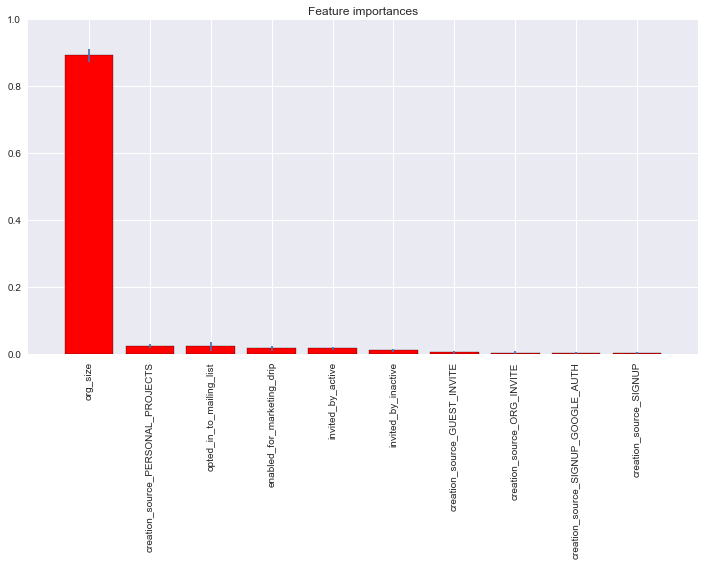

In [40]:
plot_rf_importances(forest)

In [41]:
rf = ExtraTreesClassifier(random_state=42)

In [42]:
param_dist = {"n_estimators": sp_randint(1, 1000),
              "max_depth": [3, 6, 9, 12, None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(2, 200),
              "min_samples_leaf": sp_randint(1, 200),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [43]:
clf = RandomizedSearchCV(rf, param_dist, n_iter=50, random_state=42, cv=5, n_jobs=4, verbose=10)

In [44]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   26.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   27.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   31.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   37.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Do

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002D4AB16E908>, 'criterion': ['gini', 'entropy'], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002D4AB1322B0>, 'bootstrap': [True, False], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002D4AB13AD68>, 'max_depth': [3, 6, 9, 12, None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002D4AB171588>

In [45]:
clf.score(X_test, y_test)

0.88055555555555554

In [46]:
clf.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 8,
 'min_samples_leaf': 189,
 'min_samples_split': 22,
 'n_estimators': 615}

In [47]:
new_rf = ExtraTreesClassifier(
    bootstrap=clf.best_params_['bootstrap'],
    criterion=clf.best_params_['criterion'],
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=42)

In [48]:
new_rf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=189,
           min_samples_split=22, min_weight_fraction_leaf=0.0,
           n_estimators=615, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Feature ranking:
1. creation_source_PERSONAL_PROJECTS		 (0.37250511761098754)
2. invited_by_active		 (0.15032472266913072)
3. org_size		 (0.14500139314898564)
4. creation_source_GUEST_INVITE		 (0.07487657666557462)
5. creation_source_SIGNUP_GOOGLE_AUTH		 (0.06330972296088995)
6. creation_source_ORG_INVITE		 (0.05799499964518129)
7. invited_by_inactive		 (0.051594656141697545)
8. creation_source_SIGNUP		 (0.03971865618958694)
9. opted_in_to_mailing_list		 (0.027460986439829766)
10. enabled_for_marketing_drip		 (0.01721316852813628)


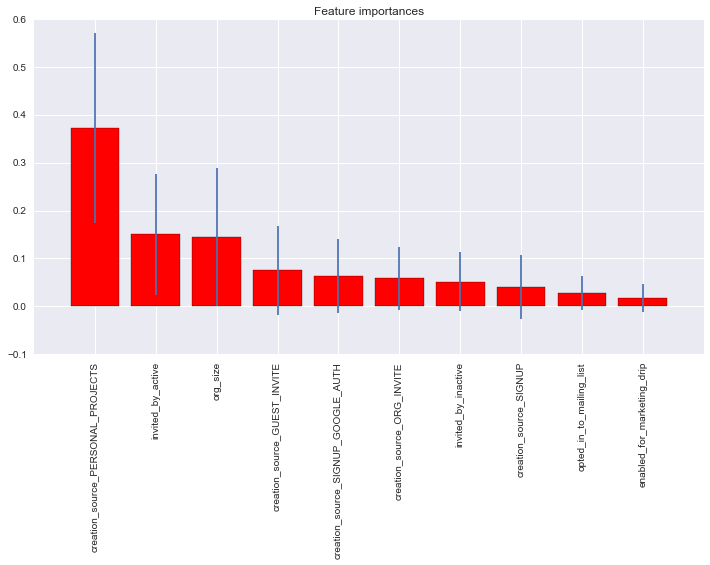

In [49]:
plot_rf_importances(new_rf)

In [50]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc(winning_rfc):
    y_test_classes = {cls:[True if c == cls else False for c in y_test ] for cls in winning_rfc.classes_.tolist()}
    rfc_result = winning_rfc.predict_proba(X_test)
    rfc_classes = winning_rfc.classes_.tolist()
    y_predicted_probs = {cls:[item[rfc_classes.index(cls)] for item in rfc_result] for cls in rfc_classes}

    fpr = {cls:[] for cls in rfc_classes}
    tpr = {cls:[] for cls in rfc_classes}

    for cls in rfc_classes:
        data = roc_curve(y_test_classes[cls]*1,y_predicted_probs[cls])
        fpr[cls] = data[0]
        tpr[cls] = data[1]

    colors = {0:'red', 1:'blue'}
    sns.set_context('talk')
    plt.figure(figsize=(12,8))
    lw = 2
    for cls in rfc_classes:
        plt.plot(fpr[cls],tpr[cls], color=colors[cls],lw=lw,label=str(cls) + ' ROC curve (area = %0.2f)' % auc(fpr[cls],tpr[cls]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('ROC')
    plt.show()

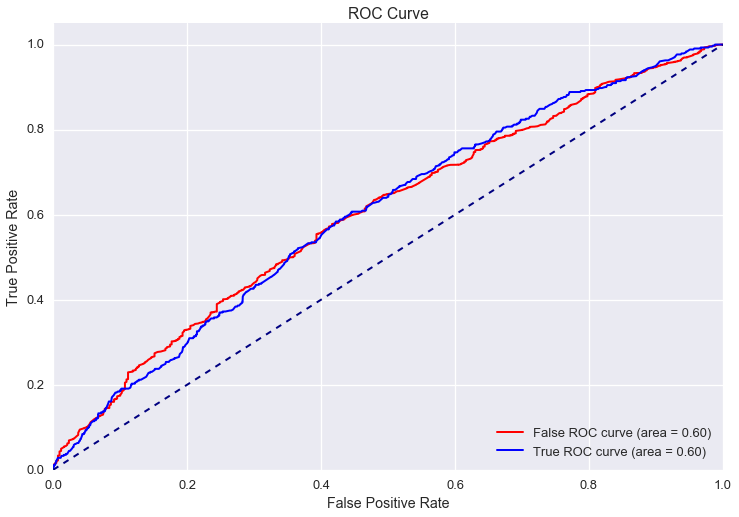

In [51]:
plot_roc(new_rf)

In [52]:
def plot_pre_rec(winning_rfc):
    y_test_classes = {cls:[True if c == cls else False for c in y_test ] for cls in winning_rfc.classes_.tolist()}
    rfc_result = winning_rfc.predict_proba(X_test)
    rfc_classes = winning_rfc.classes_.tolist()
    y_predicted_probs = {cls:[item[rfc_classes.index(cls)] for item in rfc_result] for cls in rfc_classes}
    
    pre = {cls:[] for cls in rfc_classes}
    rec = {cls:[] for cls in rfc_classes}
    
    for cls in rfc_classes:
        data = precision_recall_curve(y_test_classes[cls]*1, y_predicted_probs[cls])
        pre[cls] = data[0]
        rec[cls] = data[1]
    
    colors = {0:'red', 1:'blue'}
    sns.set_context('talk')
    plt.figure(figsize=(12,8))
    lw = 2
    for cls in rfc_classes:
        plt.plot(pre[cls],rec[cls], color=colors[cls],lw=lw,label=str(cls) + ' PR curve (area = %0.2f)' % auc(rec[cls],pre[cls]))
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('NFL PlayType RF Classifier - PR')
    plt.legend(loc="lower left")
    plt.show()

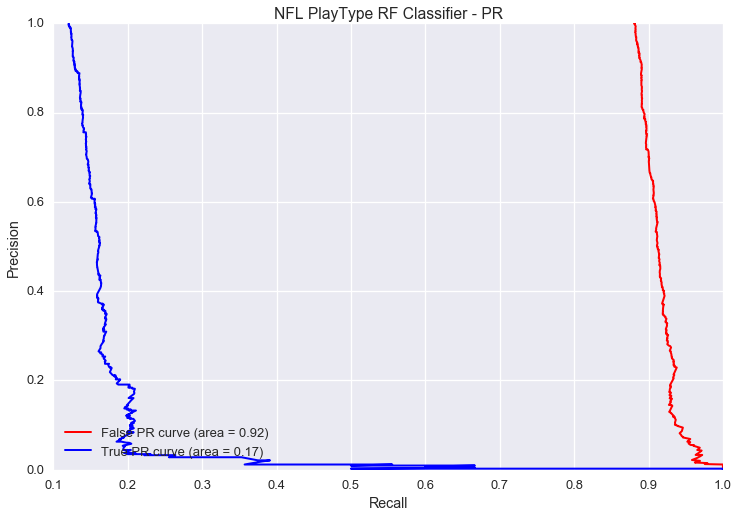

In [53]:
plot_pre_rec(new_rf)

# Results

Our model has a good score when being tested on unseen data however it's ROC and PR curves show that it does not perform as well as our 88% score indicated. We are missing some key indicators of adopted users. None the less what we have been able to learn is that Personal Project users, being invited by an active user, and organization size are all key factors for determining "adopted users".

Excluded from our model is the age of a user. The model performed extrodinarily well when that calculated factor was included, however age is a lagging indicator that does not help predict what will make a user an "adopted user". Without this factor the others have difficulty consistently predicting adoption with this model so I do believe it is worth actioning on the factors indicated above but other user factors should be incorporated to help strengthen its predictive power.